In [1]:
import os
import pandas as pd

from main import load_datasets

/scratch/users/k21193529/conda/jenv3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Get Predictions

#### Load Data

In [2]:
root = '../data_2023_06_02'

fever_dir = os.path.join(root, 'preprocessed/FEVER')
pubhealth_dir = os.path.join(root, 'preprocessed/PUBHEALTH')
climate_dir = os.path.join(root, 'preprocessed/CLIMATE-FEVER')

In [3]:
ds_fever, ds_pubhealth, ds_climate, ds_test = load_datasets(fever_dir, pubhealth_dir, climate_dir)

#### Load Experiment Settings

In [4]:
import yaml

In [5]:
with open('best_models_v3.yaml', 'r') as file:
    config = yaml.safe_load(file)

#unwind config
experiments = [
    {"model": model, "train dataset": test_set, "best_model_path": path} 
    for model, d1 in config.items() 
    for test_set, path in d1.items()
]

#### Get predictions

In [7]:
from label_analysis import get_predictions

In [9]:
# Run all experiments
results = []
for experiment in experiments:
    model_path = experiment['best_model_path']
    predictions = get_predictions(model_path, ds_test)
    for test_dataset, _df in predictions.items():
        d = experiment.copy()
        d['test_dataset'] = test_dataset
        d['predictions'] = _df.copy() 
        results.append(d)

Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate
Model loaded into cuda
Tokenizing dataset


Evaluating fever
Evaluating pubhealth
Evaluating climate


#### combine results into a single dataframe for easier analysis

In [10]:
results[0]

{'model': 'BERT',
 'train dataset': 'FEVER',
 'best_model_path': '../models/BERT_FEVER_V3/best_model',
 'test_dataset': 'fever',
 'predictions':                                                   claim  label  \
 0                               Grease had bad reviews.      2   
 1     Ukrainian Soviet Socialist Republic was a foun...      0   
 2         2 Hearts is a musical composition by Minogue.      0   
 3           The New Jersey Turnpike has zero shoulders.      1   
 4     Legendary Entertainment is the owner of Wanda ...      2   
 ...                                                 ...    ...   
 9994                        Hermit crabs are arachnids.      1   
 9995                  Michael Hutchence died on a boat.      1   
 9996  The Cyclades are located to the southeast of G...      0   
 9997                      Theresa May worked the docks.      2   
 9998       Trouble with the Curve is a television show.      1   
 
                                                ev

In [11]:
results_df = []
for d in results:
    _df = d['predictions'].copy()
    _df['model'] = d['model']
    _df['train_dataset'] = d['train dataset']
    _df['test_dataset'] = d['test_dataset']
    results_df.append(_df)

results_df = pd.concat(results_df)
print(results_df.shape)

(168465, 8)


In [12]:
results_df.to_pickle("predictions_v3-2.pkl")

#### Compute statistics by label

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [14]:
def accuracy_score_by_label(df, label):
    _df = df[df['label'] == label].copy()
    return sum(_df['correctly_classified'])/len(_df)

def get_accuracy_scores(df, labels):
    return np.array([accuracy_score_by_label(df, label) for label in labels])

def get_statistics(df, labels=[0,1,2]):
    y = df['label']
    y_pred = df['pred']

    accuracy = get_accuracy_scores(df, labels)
    precision = precision_score(y, y_pred, labels=labels, average=None)
    recall = recall_score(y, y_pred, labels=labels, average=None)
    f1 = f1_score(y, y_pred, labels=labels, average=None)

    return labels, accuracy, precision, recall, f1

In [15]:
results[0].keys()

dict_keys(['model', 'train dataset', 'best_model_path', 'test_dataset', 'predictions'])

In [16]:
def yield_statistics(results):
    for d in results:
        labels, accuracy, precision, recall, f1 = get_statistics(d['predictions']) #predictions are pandas dataframes
        for i in range(len(labels)):
            yield (
                d['model'],
                d['train dataset'],
                d['test_dataset'],
                labels[i], 
                accuracy[i], 
                precision[i], 
                recall[i], 
                f1[i]
            )

In [17]:
stats = list(yield_statistics(results))

In [18]:
stats = pd.DataFrame(stats, columns=
    ['model', 'train_dataset', 'test_dataset', 
     'labels', 'accuracy', 'precision', 'recall', 'f1']
)

In [19]:
stats

,model,train_dataset,test_dataset,labels,accuracy,precision,recall,f1
0,BERT,FEVER,fever,0,0.922892,0.905771,0.922892,0.914252
1,BERT,FEVER,fever,1,0.894689,0.922363,0.894689,0.908316
2,BERT,FEVER,fever,2,0.998200,0.987240,0.998200,0.992690
3,BERT,FEVER,pubhealth,0,0.482471,0.610994,0.482471,0.539179
4,BERT,FEVER,pubhealth,1,0.474227,0.391489,0.474227,0.428904
...,...,...,...,...,...,...,...,...
130,BioBERT,CLIMATE-FEVER,pubhealth,1,0.752577,0.365915,0.752577,0.492411
131,BioBERT,CLIMATE-FEVER,pubhealth,2,0.466667,0.098131,0.466667,0.162162
132,BioBERT,CLIMATE-FEVER,climate,0,0.136842,0.520000,0.136842,0.216667
133,BioBERT,CLIMATE-FEVER,climate,1,0.916667,0.207547,0.916667,0.338462


In [20]:
stats.to_csv('stats_by_labels_v3-2.csv', index=False)

## Aggregate Analysis

#### Plot overall results

In [248]:
# load predictions
import pandas as pd
import seaborn as sns

df = pd.read_pickle("outputs/predictions_v3-2.pkl")
print(df.shape)

(168465, 8)


In [249]:
# get table of overall accuracy
acc = df.groupby(['train_dataset','test_dataset', 'model'])['correctly_classified'].mean()*100
acc = acc.reset_index()

In [250]:
#replace labels
acc['train_dataset'].replace({
    'FEVER': 'Fine-tuned on FEVER',
    'PUBHEALTH': 'Fine-tuned on PUBHEALTH',
    'CLIMATE-FEVER': 'Fine-tuned on CLIMATE-FEVER'
}, inplace=True)

acc['test_dataset'].replace({
    'fever': 'FEVER',
    'pubhealth': 'PUBHEALTH',
    'climate': 'CLIMATE-FEVER'
}, inplace=True)

/scratch/users/k21193529/conda/jenv3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


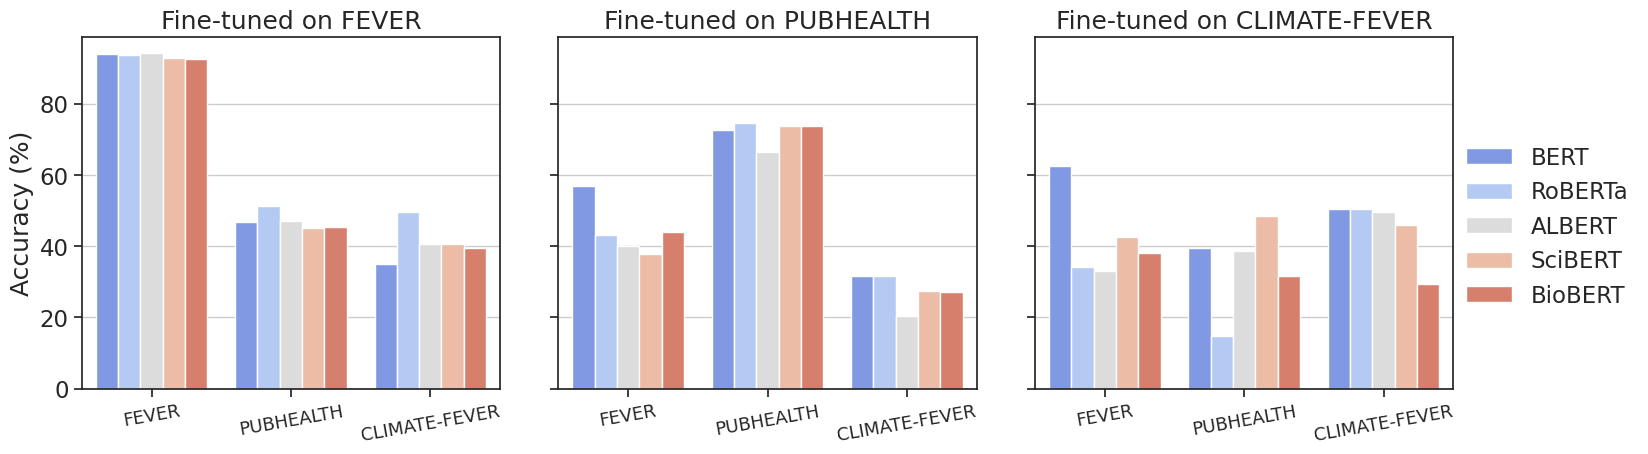

In [251]:
#plot graph
sns.set_theme(style="ticks", font_scale=1.5)
sns.set_style("ticks", { 'axes.grid': True })

g = sns.FacetGrid(
    acc, col='train_dataset', 
    col_order = ['Fine-tuned on FEVER', 'Fine-tuned on PUBHEALTH', 'Fine-tuned on CLIMATE-FEVER'],
    height=5, aspect=1, despine=False,
)

g.map_dataframe(
    sns.barplot, data=acc, x="test_dataset", y="correctly_classified", 
    order = ['FEVER', 'PUBHEALTH', 'CLIMATE-FEVER'],
    hue_order = ['BERT', 'RoBERTa', 'ALBERT', 'SciBERT', 'BioBERT'],
    hue="model", errorbar=None,
    palette="coolwarm",
)

g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_xlabels("")
g.set_ylabels('Accuracy (%)')
g.set_xticklabels(rotation=10, fontsize=13)

/scratch/users/k21193529/conda/jenv3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


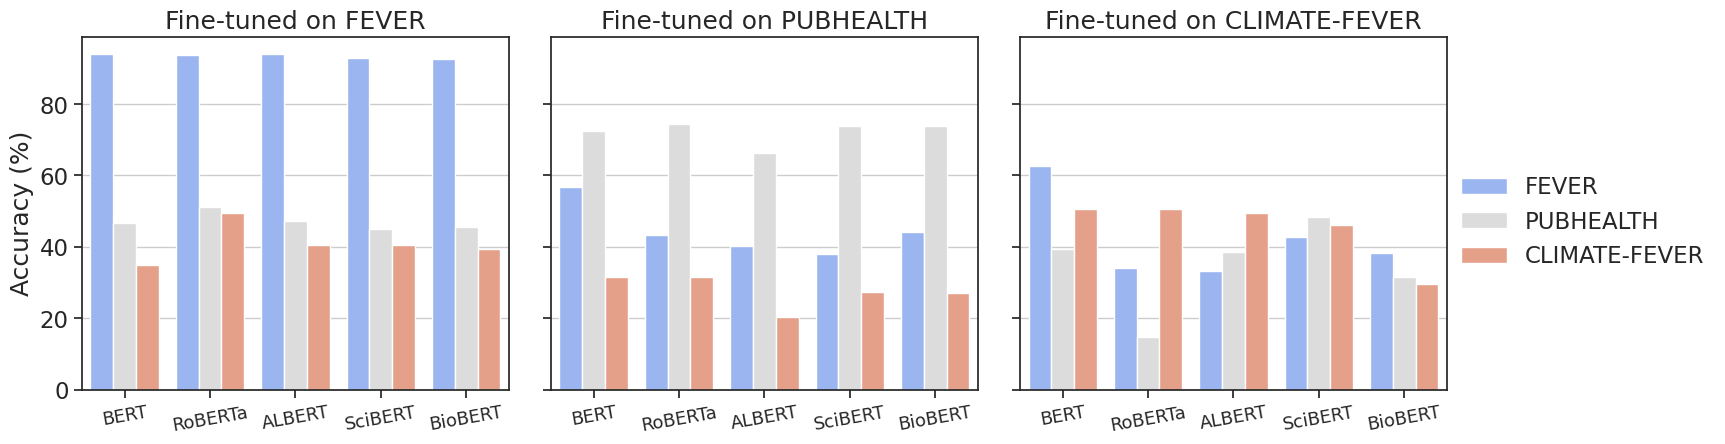

In [252]:
#plot graph
sns.set_theme(style="ticks", font_scale=1.5)
sns.set_style("ticks", { 'axes.grid': True })

g = sns.FacetGrid(
    acc, col='train_dataset', 
    col_order = ['Fine-tuned on FEVER', 'Fine-tuned on PUBHEALTH', 'Fine-tuned on CLIMATE-FEVER'],
    height=5, aspect=1, despine=False,
)

g.map_dataframe(
    sns.barplot, data=acc, x="model", y="correctly_classified", 
    order = ['BERT', 'RoBERTa', 'ALBERT', 'SciBERT', 'BioBERT'],
    hue="test_dataset", errorbar=None,
    hue_order = ['FEVER', 'PUBHEALTH', 'CLIMATE-FEVER'],
    palette="coolwarm",
)

g.add_legend()
g.set_titles(col_template="{col_name}")
g.set_xlabels("")
g.set_ylabels('Accuracy (%)')
g.set_xticklabels(rotation=10, fontsize=13)

In [253]:
g.figure.savefig("figures/overall_results_v3-2_(bymodel).png")

#### Plot Line Graph of Statistics by Label

In [21]:
import seaborn as sns
import pandas as pd

In [235]:
# load stats
stats = pd.read_csv('stats_by_labels_v3-2.csv')

# convert stats to percentage
cols = ['accuracy', 'precision', 'recall', 'f1']
for col in cols:
    stats[col] = stats[col]*100

# replace labels
stats['labels'].replace({
    0: 'SUPPORTS',
    1: 'REFUTES',
    2: 'NOT ENOUGH INFO'
}, inplace=True)

stats['train_dataset'].replace({
    'FEVER': 'Fine-tuned \n on FEVER',
    'PUBHEALTH': 'Fine-tuned on \n PUBHEALTH',
    'CLIMATE-FEVER': 'Fine-tuned on \n CLIMATE-FEVER'
}, inplace=True)

stats['test_dataset'].replace({
    'fever': 'FEVER',
    'pubhealth': 'PUBHEALTH',
    'climate': 'CLIMATE-FEVER'
}, inplace=True)

In [236]:
stats.head()

,model,train_dataset,test_dataset,labels,accuracy,precision,recall,f1
0,BERT,Fine-tuned \n on FEVER,FEVER,SUPPORTS,92.289229,90.577150,92.289229,91.425175
1,BERT,Fine-tuned \n on FEVER,FEVER,REFUTES,89.468947,92.236313,89.468947,90.831557
2,BERT,Fine-tuned \n on FEVER,FEVER,NOT ENOUGH INFO,99.819982,98.724036,99.819982,99.268984
3,BERT,Fine-tuned \n on FEVER,PUBHEALTH,SUPPORTS,48.247078,61.099366,48.247078,53.917910
4,BERT,Fine-tuned \n on FEVER,PUBHEALTH,REFUTES,47.422680,39.148936,47.422680,42.890443


In [237]:
sns.set_theme(style="ticks", font_scale=1.2)
sns.set_style("ticks", { 'axes.grid': False })

/scratch/users/k21193529/conda/jenv3/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


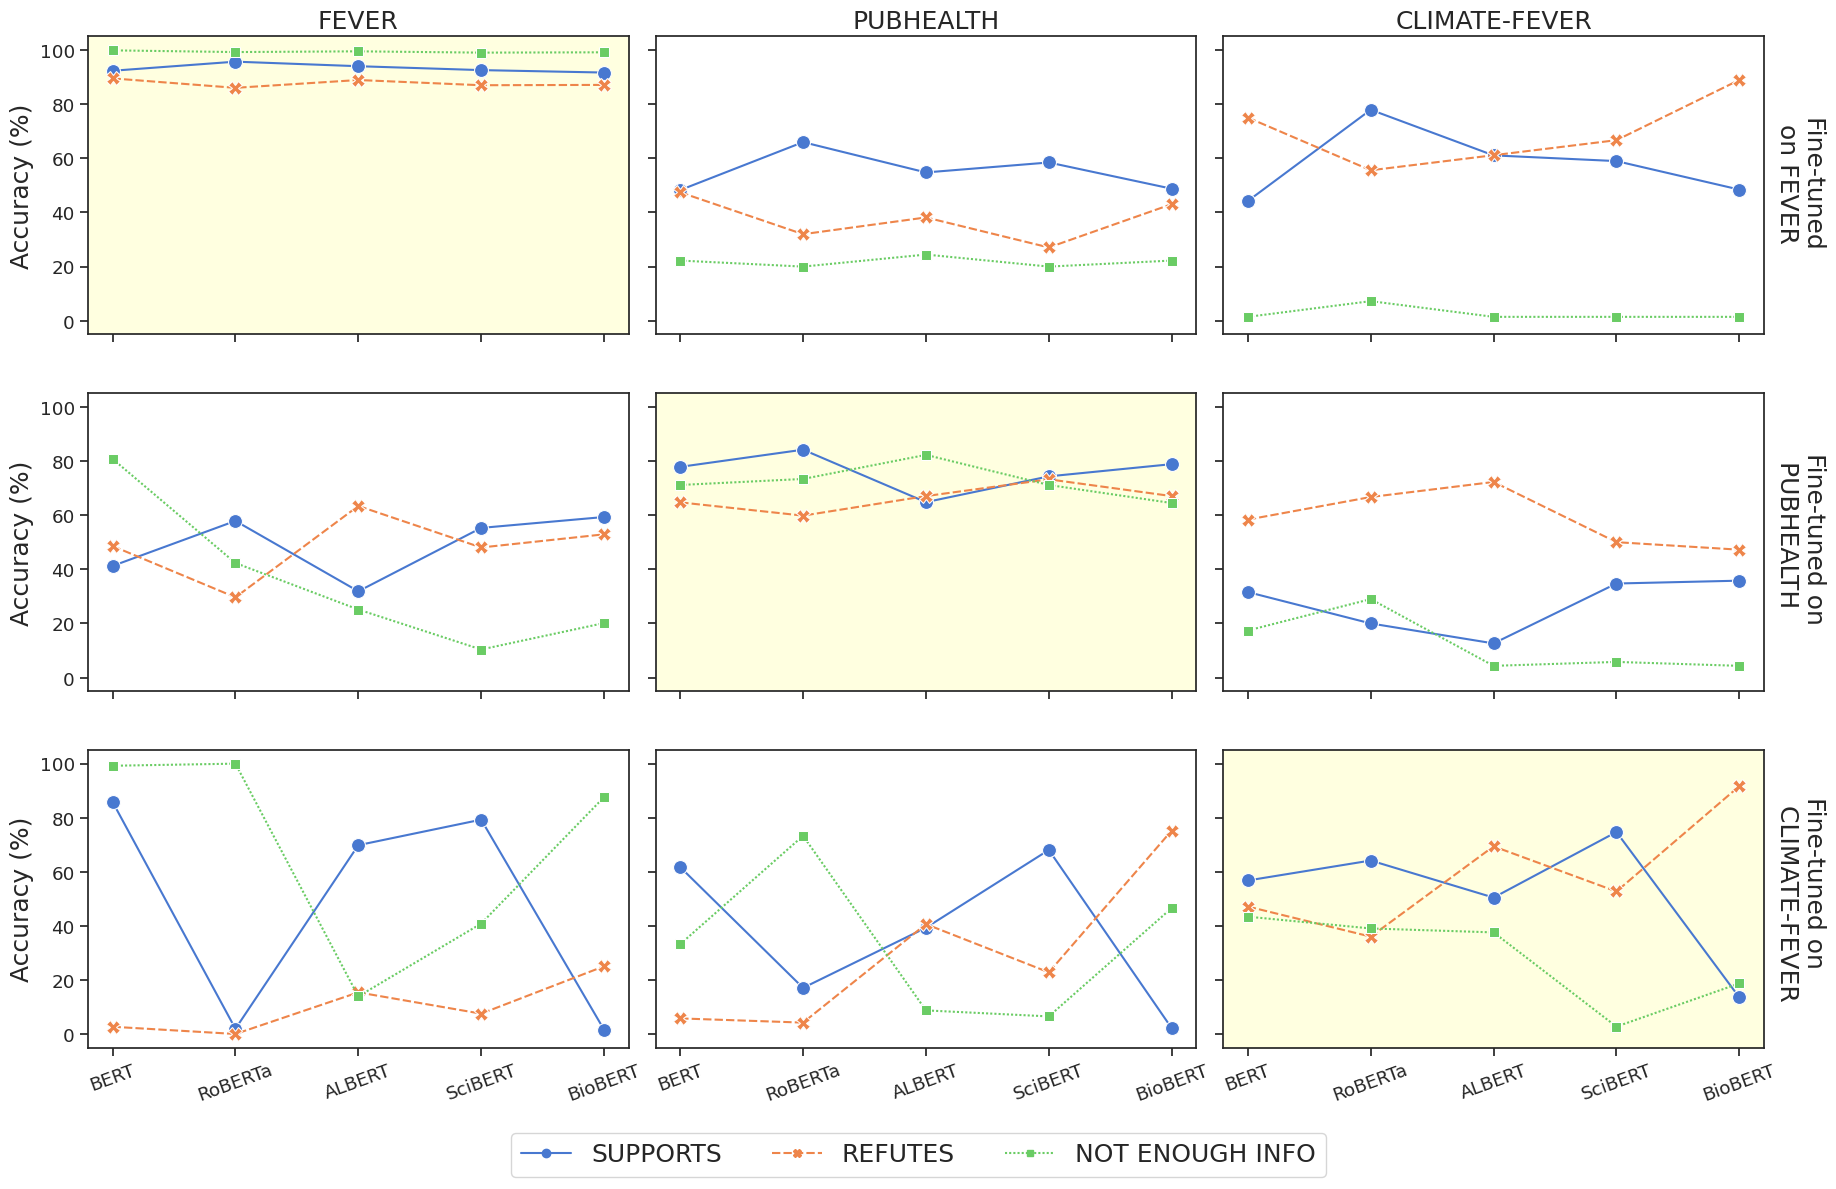

In [238]:
fontsize=18

g = sns.FacetGrid(
    stats, 
    row='train_dataset',
    col='test_dataset',
    height=4, aspect=1.6, 
    despine=False,
    margin_titles=True
)

g.map_dataframe(
    sns.lineplot, 
    data=stats, 
    x='model',
    y='accuracy', 
    hue='labels',
    style='labels',
    markers=True,
    err_style=None,
    palette="muted",
    markersize=10  #default 6
)

g.add_legend(loc="lower center", ncol=3, fontsize=fontsize, frameon=True)
g.set_titles(
    col_template="{col_name}", 
    row_template="{row_name}", 
    size=fontsize, 
    horizontalalignment="center"
)
g.set_xlabels("")
g.set_ylabels("Accuracy (%)", fontsize=fontsize)
g.set_xticklabels(
    labels=["BERT", "RoBERTa", "ALBERT", "SciBERT", "BioBERT"], 
    rotation=20
)

g.figure.subplots_adjust(
    wspace=.05, 
    hspace=.2,
    bottom=0.12
)

subplot_bg = "lightyellow"
g.axes[0][0].set_facecolor(subplot_bg)
g.axes[1][1].set_facecolor(subplot_bg)
g.axes[2][2].set_facecolor(subplot_bg)

In [239]:
g.figure.savefig("accuracy_by_labels_v3-2.png", bbox_inches='tight')

## Error Analysis

In [220]:
import pandas as pd

df = pd.read_pickle("predictions_v1.pkl")
print(df.shape)

(168465, 8)


#### Get samples that are misclassified by all models

In [221]:
df.reset_index(inplace=True, drop=True)
df.drop_duplicates(
    subset=['model','claim', 'label', 'train_dataset', 'test_dataset'],
    inplace=True,
)
print(df.shape)

(166620, 8)


In [229]:
pivoted_df = df.pivot(index=['claim', 'evidence', 'label', 'train_dataset', 'test_dataset'], columns='model', values='pred').reset_index()

In [231]:
models = ['ALBERT','BERT', 'BioBERT', 'RoBERTa', 'SciBERT']
for model in models:
    pivoted_df[f"{model}_correct"] = pivoted_df[model] == pivoted_df["label"]

In [232]:
pivoted_df['misclassified_all'] = ~pivoted_df[[f"{model}_correct" for model in models]].any(axis=1)

In [233]:
err_all = pivoted_df[pivoted_df['misclassified_all'] == True]
print(err_all.shape)

(8673, 16)


In [234]:
err_all.to_csv('err_samples_all_v1.csv')

#### Sample misclassified data points for analysis

In [88]:
err_samples = df[df['correctly_classified'] == False].\
    groupby(['train_dataset', 'model', 'test_dataset', 'label']).sample(2, random_state=525)
print(err_samples.shape)

(270, 8)


In [95]:
err_samples.to_csv('err_samples_v1.csv')

In [96]:
err_samples.loc[95].to_dict()

{'claim': 'the kind of extreme heat we saw this past summer will be the norm',
 'label': 0,
 'evidence': 'August 2018 was hotter and windier than the average. Summer 2013–14 was warmer than average for the entirety of Australia. Summers are generally hot and dry, lasting from December to March, with February generally the hottest month. Under the Köppen–Geiger classification, Sydney has a humid subtropical climate (Cfa) with warm summers, cool winters and uniform rainfall throughout the year. The summer of 2007–08, however, proved to be the coolest since 1996–97 and is the only summer this century to be at or below average in temperatures.',
 'pred': 1,
 'correctly_classified': False,
 'model': 'ALBERT',
 'train_dataset': 'FEVER',
 'test_dataset': 'climate'}

In [109]:
df.query("test_dataset == 'fever' & label == 2").sample(10)

,claim,label,evidence,pred,correctly_classified,model,train_dataset,test_dataset
3106,Milk is based on the life of an animal rights ...,2,Paraná is a municipality in the state of Rio G...,0,False,SciBERT,PUBHEALTH,fever
5941,James Spader starred in a controversial 1987 f...,2,It is the head town of the Tulumba Department .,2,True,ALBERT,FEVER,fever
5942,SummerSlam had no viewers.,2,Samuel Enderby & Sons was a whaling and sealin...,2,True,SciBERT,FEVER,fever
2135,The Silver Surfer appears in comic books publi...,2,Various sections are urban four-lane highway a...,2,True,BERT,CLIMATE-FEVER,fever
7513,The Premier League Asia Trophy is for grave di...,2,"After a seven-year hiatus , they released Da R...",2,True,ALBERT,FEVER,fever
9634,Bonaire is one of the three BES islands in the...,2,The team finished 3-1 .,0,False,RoBERTa,PUBHEALTH,fever
3889,"Deepika Padukone has acted in tragedies, horro...",2,Faith 's E5 status allowed her to be recognize...,2,True,ALBERT,FEVER,fever
319,Timur participated in an election.,2,The wingspan is about 32 mm .,2,True,BioBERT,FEVER,fever
6496,Bala's has directed at least four films.,2,The album was released on 24 September 1991 un...,2,True,BioBERT,FEVER,fever
7120,Mike Friedrich is from America.,2,Chagang Province -LRB- Chagangdo ; -LSB- tsa.ɡ...,2,True,RoBERTa,CLIMATE-FEVER,fever


In [103]:
df[df['claim'].str.contains("Ukrainian Soviet Socialist Republic was a founding member of the UN.")]

,claim,label,evidence,pred,correctly_classified,model,train_dataset,test_dataset
3343,Ukrainian Soviet Socialist Republic was a foun...,0,The Ukrainian SSR was a founding member of the...,1,False,BERT,FEVER,fever
3646,Ukrainian Soviet Socialist Republic was a foun...,2,Lǐ Lián -LRB- 740 ?,2,True,BERT,FEVER,fever
3343,Ukrainian Soviet Socialist Republic was a foun...,0,The Ukrainian SSR was a founding member of the...,0,True,BERT,PUBHEALTH,fever
3646,Ukrainian Soviet Socialist Republic was a foun...,2,Lǐ Lián -LRB- 740 ?,1,False,BERT,PUBHEALTH,fever
3343,Ukrainian Soviet Socialist Republic was a foun...,0,The Ukrainian SSR was a founding member of the...,0,True,BERT,CLIMATE-FEVER,fever
3646,Ukrainian Soviet Socialist Republic was a foun...,2,Lǐ Lián -LRB- 740 ?,2,True,BERT,CLIMATE-FEVER,fever
3343,Ukrainian Soviet Socialist Republic was a foun...,0,The Ukrainian SSR was a founding member of the...,0,True,RoBERTa,FEVER,fever
3646,Ukrainian Soviet Socialist Republic was a foun...,2,Lǐ Lián -LRB- 740 ?,2,True,RoBERTa,FEVER,fever
3343,Ukrainian Soviet Socialist Republic was a foun...,0,The Ukrainian SSR was a founding member of the...,0,True,RoBERTa,PUBHEALTH,fever
3646,Ukrainian Soviet Socialist Republic was a foun...,2,Lǐ Lián -LRB- 740 ?,1,False,RoBERTa,PUBHEALTH,fever
